# Convolutional Neural Networks

**Handling image data**

Joaquin Vanschoren, Eindhoven University of Technology

## Overview

* Image convolution
* Convolutional neural networks
* Data augmentation
* Model interpretation
* Using pre-trained networks (transfer learning)

In [1]:
# Global imports and settings
from preamble import *
import tensorflow as tf
print("Using Keras",tf.keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:100% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Using Keras 2.2.4-tf


In [2]:
base_dir = '../data/cats-vs-dogs_small'
model_dir = '../data/models'

**Note: if you want to run this notebook in Google Colab on a GPU:**
- upload the `data` folder to your Google Drive
- In Colab, left menu > Files, mount your Drive
- Change the above code to
```python
base_dir = '/content/drive/My Drive/data/cats-vs-dogs_small'
model_dir = '/content/drive/My Drive/data/models'
```
- Under Edit > Notebook Settings, choose Hardware Accelerator: GPU

### Convolution
* Operation that transforms an image by sliding a smaller image (called a _filter_ or _kernel_ ) over the image and multiplying the pixel values
    * Slide an $n$ x $n$ filter over $n$ x $n$ _patches_ of the original image
    * Every pixel is replaced by the _sum_ of the _element-wise products_ of the values of the image patch around that pixel and the kernel 

``` python
# kernel and image_patch are n x n matrices
pixel_out = np.sum(kernel * image_patch)
```

<img src="../images/10_conv_filtering.png" alt="ml" style="width: 500px; margin-left: auto; margin-right: auto;"/>

In [3]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from skimage import color


# Visualize convolution. See https://tonysyu.github.io/
def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]
            
# Visualize result
def imshow_pair(image_pair, titles=('', ''), figsize=(10, 5), **kwargs):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    for ax, img, label in zip(axes.ravel(), image_pair, titles):
        ax.imshow(img, **kwargs)
        ax.set_title(label)
        
# Visualize result
def imshow_triple(axes, image_pair, titles=('', '', ''), figsize=(10, 5), **kwargs):
    for ax, img, label in zip(axes, image_pair, titles):
        ax.imshow(img, **kwargs)
        ax.set_title(label, fontdict={'fontsize':8})
        ax.set_xticks([])
        ax.set_yticks([])
        
# Zero-padding
def padding_for_kernel(kernel):
    """ Return the amount of padding needed for each side of an image.

    For example, if the returned result is [1, 2], then this means an
    image should be padded with 1 extra row on top and bottom, and 2
    extra columns on the left and right.
    """
    # Slice to ignore RGB channels if they exist.
    image_shape = kernel.shape[:2]
    # We only handle kernels with odd dimensions so make sure that's true.
    # (The "center" pixel of an even number of pixels is arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]
def add_padding(image, kernel):
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)),
                  mode='constant', constant_values=0)
def remove_padding(image, kernel):
    inner_region = []  # A 2D slice for grabbing the inner image region
    for pad in padding_for_kernel(kernel):
        slice_i = slice(None) if pad == 0 else slice(pad, -pad)
        inner_region.append(slice_i)
    return image[inner_region]

# Slice windows
def window_slice(center, kernel):
    r, c = center
    r_pad, c_pad = padding_for_kernel(kernel)
    # Slicing is (inclusive, exclusive) so add 1 to the stop value
    return [slice(r-r_pad, r+r_pad+1), slice(c-c_pad, c+c_pad+1)]

# Apply convolution kernel to image patch
def apply_kernel(center, kernel, original_image):
    image_patch = original_image[window_slice(center, kernel)]
    # An element-wise multiplication followed by the sum
    return np.sum(kernel * image_patch)

# Move kernel over the image
def iter_kernel_labels(image, kernel):
    original_image = image
    image = add_padding(original_image, kernel)
    i_pad, j_pad = padding_for_kernel(kernel)

    for (i, j), pixel in iter_pixels(original_image):
        # Shift the center of the kernel to ignore padded border.
        i += i_pad
        j += j_pad
        mask = np.zeros(image.shape, dtype=int)  # Background = 0
        mask[window_slice((i, j), kernel)] = kernel   # Kernel = 1
        #mask[i, j] = 2                           # Kernel-center = 2
        yield (i, j), mask

# Visualize kernel as it moves over the image
def visualize_kernel(kernel_labels, image):
    return kernel_labels + image #color.label2rgb(kernel_labels, image, bg_label=0)

# Do a single step
def convolution_demo(image, kernel, **kwargs):
    # Initialize generator since we're only ever going to iterate over
    # a pixel once. The cached result is used, if we step back.
    gen_kernel_labels = iter_kernel_labels(image, kernel)

    image_cache = []
    image_padded = add_padding(image, kernel)
    # Plot original image and kernel-overlay next to filtered image.
    @interact(i_step=(0, image.size-1,1))
    def convolution_step(i_step=0):
        # Create all images up to the current step, unless they're already
        # cached:
        while i_step >= len(image_cache):

            # For the first step (`i_step == 0`), the original image is the
            # filtered image; after that we look in the cache, which stores
            # (`kernel_overlay`, `filtered`).
            filtered_prev = image_padded if i_step == 0 else image_cache[-1][1]
            # We don't want to overwrite the previously filtered image:
            filtered = filtered_prev.copy()

            # Get the labels used to visualize the kernel
            center, kernel_labels = next(gen_kernel_labels)
            # Modify the pixel value at the kernel center
            filtered[center] = apply_kernel(center, kernel, image_padded)
            # Take the original image and overlay our kernel visualization
            kernel_overlay = visualize_kernel(kernel_labels, image_padded)
            # Save images for reuse.
            image_cache.append((kernel_overlay, filtered))

        # Remove padding we added to deal with boundary conditions
        # (Loop since each step has 2 images)
        image_pair = [remove_padding(each, kernel)
                      for each in image_cache[i_step]]
        imshow_pair(image_pair, **kwargs)
        plt.show()

    return convolution_step

# Full process
def convolution_full(ax, image, kernel, **kwargs):
    # Initialize generator since we're only ever going to iterate over
    # a pixel once. The cached result is used, if we step back.
    gen_kernel_labels = iter_kernel_labels(image, kernel)

    image_cache = []
    image_padded = add_padding(image, kernel)
    # Plot original image and kernel-overlay next to filtered image.

    for i_step in range(image.size-1):

        # For the first step (`i_step == 0`), the original image is the
        # filtered image; after that we look in the cache, which stores
        # (`kernel_overlay`, `filtered`).
        filtered_prev = image_padded if i_step == 0 else image_cache[-1][1]
        # We don't want to overwrite the previously filtered image:
        filtered = filtered_prev.copy()

        # Get the labels used to visualize the kernel
        center, kernel_labels = next(gen_kernel_labels)
        # Modify the pixel value at the kernel center
        filtered[center] = apply_kernel(center, kernel, image_padded)
        # Take the original image and overlay our kernel visualization
        kernel_overlay = visualize_kernel(kernel_labels, image_padded)
        # Save images for reuse.
        image_cache.append((kernel_overlay, filtered))

    # Remove padding we added to deal with boundary conditions
    # (Loop since each step has 2 images)
    image_triple = [remove_padding(each, kernel)
                  for each in image_cache[i_step]]
    image_triple.insert(1,kernel)
    imshow_triple(ax, image_triple, **kwargs)

* Different kernels can detect different types of patterns in the image

In [4]:
horizontal_edge_kernel = np.array([[ 1,  2,  1],
                                   [ 0,  0,  0],
                                   [-1, -2, -1]])
diagonal_edge_kernel = np.array([[1, 0, 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
edge_detect_kernel = np.array([[-1, -1, -1],
                               [-1,  8, -1],
                               [-1, -1, -1]])

Demonstration

In [5]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
# Get the predictors X and the labels y
X_mnist, y_mnist, c, a = mnist_data.get_data(dataset_format='array', target=mnist_data.default_target_attribute); 
image = X_mnist[1].reshape((28, 28))
image = (image - np.min(image))/np.ptp(image) # Normalize

titles = ('Image and kernel', 'Filtered image')
convolution_demo(image, horizontal_edge_kernel, vmin=-4, vmax=4, titles=titles, cmap='gray_r');

interactive(children=(IntSlider(value=0, description='i_step', max=783), Output()), _dom_classes=('widget-inte…

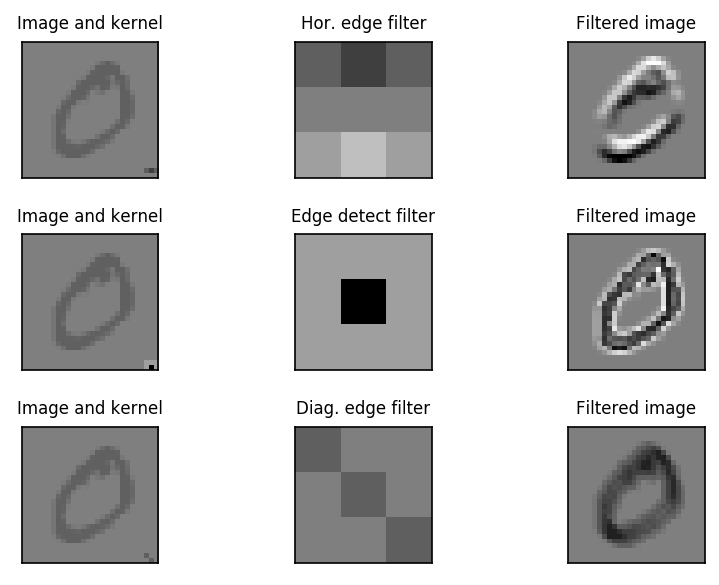

In [6]:
plt.rcParams['figure.dpi'] = 150
fig, axs = plt.subplots(3, 3)
titles = ('Image and kernel', 'Hor. edge filter', 'Filtered image')
convolution_full(axs[0,:], image, horizontal_edge_kernel, vmin=-4, vmax=4, titles=titles, cmap='gray_r')
titles = ('Image and kernel', 'Edge detect filter', 'Filtered image')
convolution_full(axs[1,:], image, edge_detect_kernel, vmin=-4, vmax=4, titles=titles, cmap='gray_r')
titles = ('Image and kernel', 'Diag. edge filter', 'Filtered image')
convolution_full(axs[2,:], image, diagonal_edge_kernel, vmin=-4, vmax=4, titles=titles, cmap='gray_r')
plt.tight_layout()

### Demonstration on Google streetview data
House numbers photographed from Google streetview imagery, cropped and centered around digits, but with neighboring numbers or other edge artifacts.

In [7]:
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

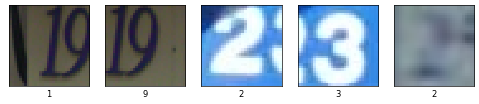

In [8]:
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n].reshape(32, 32)/255, cmap='gray')
        else:
            axes[n].imshow(X[n].reshape(32, 32, 3)/255)
        axes[n].set_xlabel((y[n]+1)) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = range(5)
X_sub_color = [X[i] for i in images]
y_sub = [y[i] for i in images]
plt.rcParams['figure.dpi'] = 60
plot_images(X_sub_color, y_sub)

For recognizing digits, color is not important, so we grayscale the images

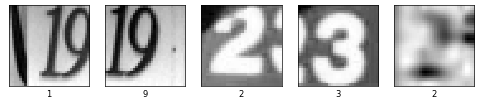

In [9]:
def rgb2gray(X, dim=32):
    return np.expand_dims(np.dot(X.reshape(len(X), dim*dim, 3), [0.2990, 0.5870, 0.1140]), axis=2)
Xsm = rgb2gray(X[:100])

X_sub = [Xsm[i] for i in images]
plot_images(X_sub, y_sub, grayscale=True)

Demonstration

In [14]:
plt.rcParams['figure.dpi'] = 100
def normalize_image(X):
    image = X.reshape((32, 32))
    return (image - np.min(image))/np.ptp(image) # Normalize

image = normalize_image(X_sub[3])
demo2 = convolution_demo(image, horizontal_edge_kernel,
                 vmin=-4, vmax=4, cmap='gray_r');

interactive(children=(IntSlider(value=0, description='i_step', max=1023), Output()), _dom_classes=('widget-int…

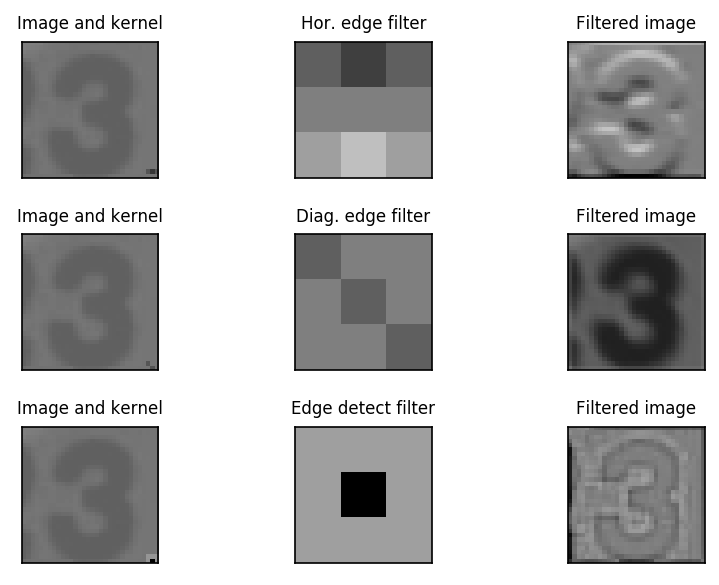

In [15]:
plt.rcParams['figure.dpi'] = 150
fig, axs = plt.subplots(3, 3)
titles = ('Image and kernel', 'Hor. edge filter', 'Filtered image')
convolution_full(axs[0,:], image, horizontal_edge_kernel, vmin=-4, vmax=4, titles=titles, cmap='gray_r')
titles = ('Image and kernel', 'Diag. edge filter', 'Filtered image')
convolution_full(axs[1,:], image, diagonal_edge_kernel, vmin=-4, vmax=4, titles=titles, cmap='gray_r')
titles = ('Image and kernel', 'Edge detect filter', 'Filtered image')
convolution_full(axs[2,:], image, edge_detect_kernel, vmin=-4, vmax=4, titles=titles, cmap='gray_r')
plt.tight_layout()

### Image convolution in practice
* How do we know which filters are best for a given image?
* _Families_ of kernels (or _filter banks_ ) can be run on every image
    * Gabor, Sobel, Haar Wavelets,...
* Gabor filters: Wave patterns generated by changing:
    - Frequency: narrow or wide ondulations
    - Theta: angle (direction) of the wave
    - Sigma: resolution (size of the filter)

Demonstration

In [16]:
from scipy import ndimage as ndi
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

# Gabor Filters.
@interact
def demoGabor(frequency=(0.01,1,0.05), theta=(0,3.14,0.1), sigma=(0,5,0.1)):
    plt.gray()
    plt.imshow(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)), interpolation='nearest')

interactive(children=(FloatSlider(value=0.46, description='frequency', max=1.0, min=0.01, step=0.05), FloatSli…

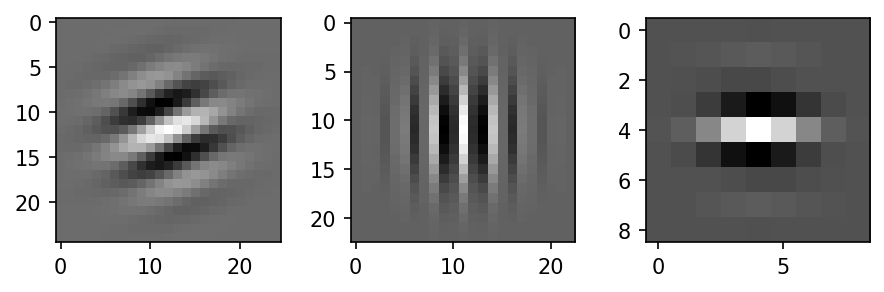

In [17]:
plt.subplot(1, 3, 1)
demoGabor(frequency=0.16, theta=1.2, sigma=4.0)
plt.subplot(1, 3, 2)
demoGabor(frequency=0.31, theta=0, sigma=3.6)
plt.subplot(1, 3, 3)
demoGabor(frequency=0.36, theta=1.6, sigma=1.3)
plt.tight_layout()

Demonstration on the streetview data

In [18]:
# Calculate the magnitude of the Gabor filter response given a kernel and an imput image
def magnitude(image, kernel):
    image = (image - image.mean()) / image.std() # Normalize images
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

In [19]:
@interact
def demoGabor2(frequency=(0.01,1,0.05), theta=(0,3.14,0.1), sigma=(0,5,0.1)):
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Gabor kernel')
    plt.imshow(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)), interpolation='nearest')
    plt.subplot(133)
    plt.title('Response magnitude')
    plt.imshow(np.real(magnitude(image, gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))), interpolation='nearest')
    plt.tight_layout()

interactive(children=(FloatSlider(value=0.46, description='frequency', max=1.0, min=0.01, step=0.05), FloatSli…

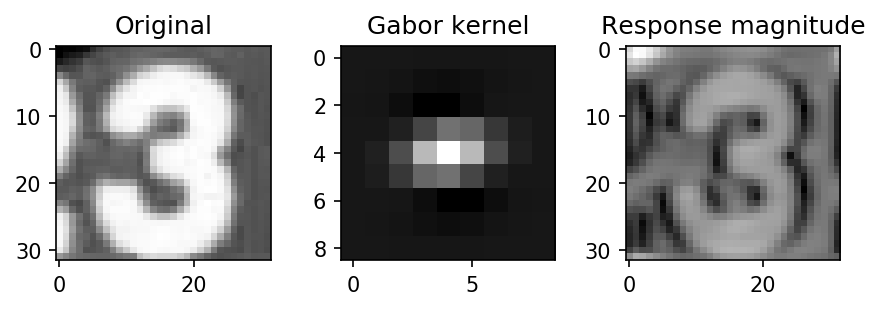

In [20]:
demoGabor2(frequency=0.16, theta=1.4, sigma=1.2)

### Filter banks
- Different filters detect different edges, shapes,...
- Not all seem useful

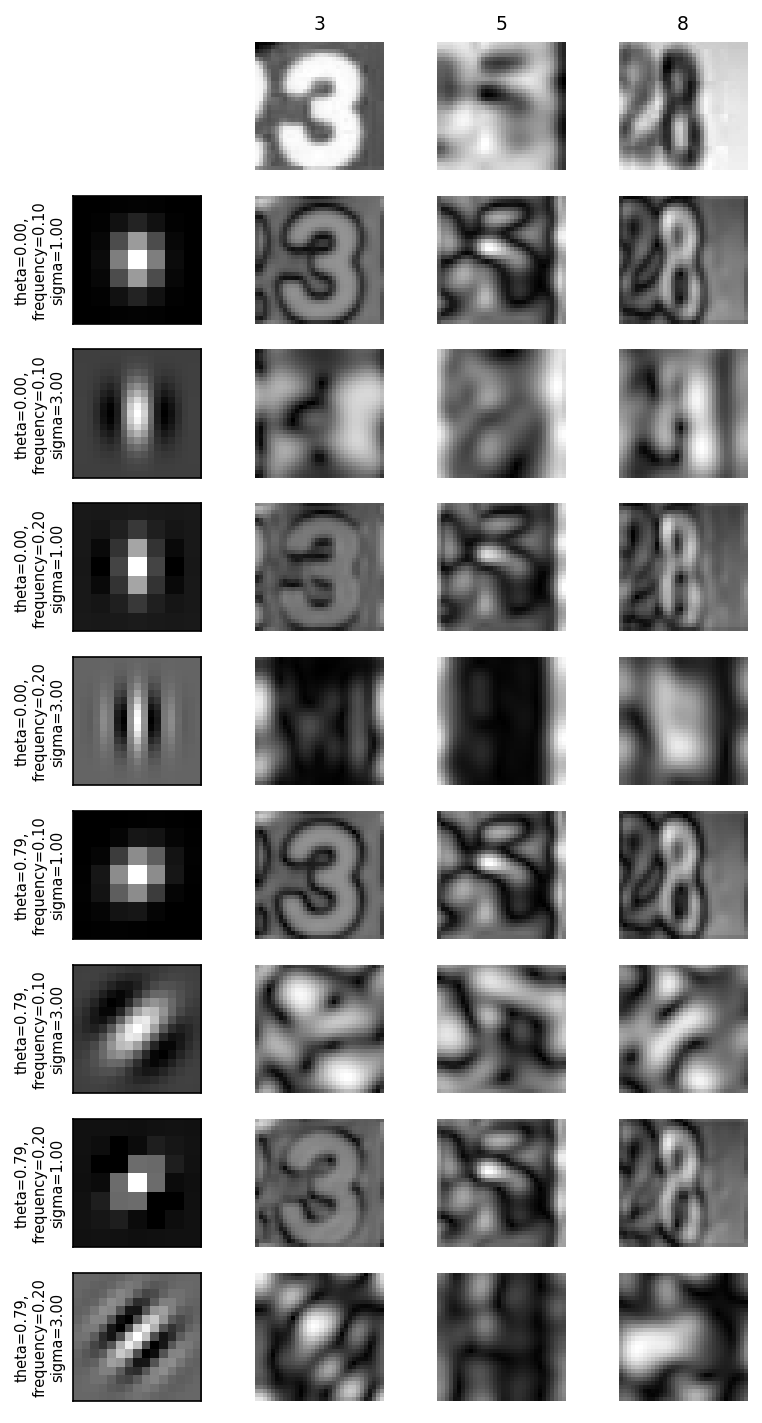

In [17]:
# More images
image3 = normalize_image(Xsm[3])
image5 = normalize_image(Xsm[5])
image13 = normalize_image(Xsm[13])

image_names = ('3', '5', '8') # labels
images = (image3, image5, image13)

def plot_filter_bank(images):
    # Create a set of kernels, apply them to each image, store the results
    results = []
    kernel_params = []
    for theta in (0, 1):
        theta = theta / 4. * np.pi
        for frequency in (0.1, 0.2):
            for sigma in (1, 3):
                kernel = gabor_kernel(frequency, theta=theta,sigma_x=sigma,sigma_y=sigma)
                params = 'theta=%.2f,\nfrequency=%.2f\nsigma=%.2f' % (theta, frequency, sigma)
                kernel_params.append(params)
                results.append((kernel, [magnitude(img, kernel) for img in images]))

    # Plotting
    fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(6, 12))
    plt.gray()
    #fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
    axes[0][0].axis('off')

    # Plot original images
    for label, img, ax in zip(image_names, images, axes[0][1:]):
        ax.imshow(img)
        ax.set_title(label, fontsize=9)
        ax.axis('off')

    for label, (kernel, magnitudes), ax_row in zip(kernel_params, results, axes[1:]):
        # Plot Gabor kernel
        ax = ax_row[0]
        ax.imshow(np.real(kernel), interpolation='nearest') # Plot kernel
        ax.set_ylabel(label, fontsize=7)
        ax.set_xticks([]) # Remove axis ticks 
        ax.set_yticks([])

        # Plot Gabor responses with the contrast normalized for each filter
        vmin = np.min(magnitudes)
        vmax = np.max(magnitudes)
        for patch, ax in zip(magnitudes, ax_row[1:]):
            ax.imshow(patch, vmin=vmin, vmax=vmax) # Plot convolutions
            ax.axis('off')
    
    plt.rcParams['figure.dpi'] = 80
    plt.show()

plot_filter_bank(images)
plt.rcParams['figure.dpi'] = 100

Another example: Fashion MNIST

In [18]:
fmnist_data = oml.datasets.get_dataset(40996) # Download FMNIST data
# Get the predictors X and the labels y
X_fm, y_fm, c, a = fmnist_data.get_data(dataset_format='array', target=fmnist_data.default_target_attribute); 

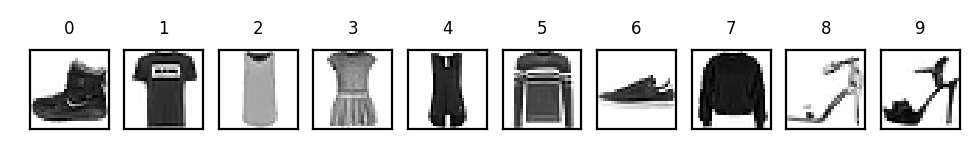

In [19]:
plt.rcParams['figure.dpi'] = 200
# build a list of figures for plotting
def buildFigureList(fig, subfiglist, titles, length):
    for i in range(0,length):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(1,length,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.set_title(titles[i], fontsize=6)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

subfiglist = []
titles=[]

for i in range(0,10):
    subfiglist.append(X_fm[i])
    titles.append(i)

buildFigureList(plt.figure(1),subfiglist, titles, 10)
plt.show()

Demonstration

In [23]:
plt.rcParams['figure.dpi'] = 100
boot = X_fm[0].reshape((28, 28))
image2=boot
@interact
def demoGabor3(frequency=(0.01,1,0.05), theta=(0,3.14,0.1), sigma=(0,5,0.1)):
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(image2)
    plt.subplot(132)
    plt.title('Gabor kernel')
    plt.imshow(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)), interpolation='nearest')
    plt.subplot(133)
    plt.title('Response magnitude')
    plt.imshow(np.real(magnitude(image2, gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))), interpolation='nearest')

interactive(children=(FloatSlider(value=0.46, description='frequency', max=1.0, min=0.01, step=0.05), FloatSli…

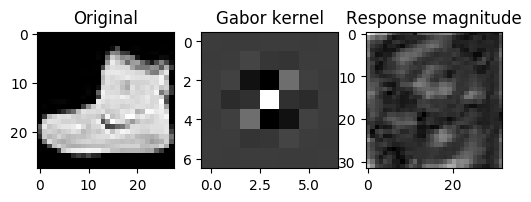

In [21]:
demoGabor3(frequency=0.81, theta=2.7, sigma=0.9)

Fashion MNIST with multiple filters (filter bank)

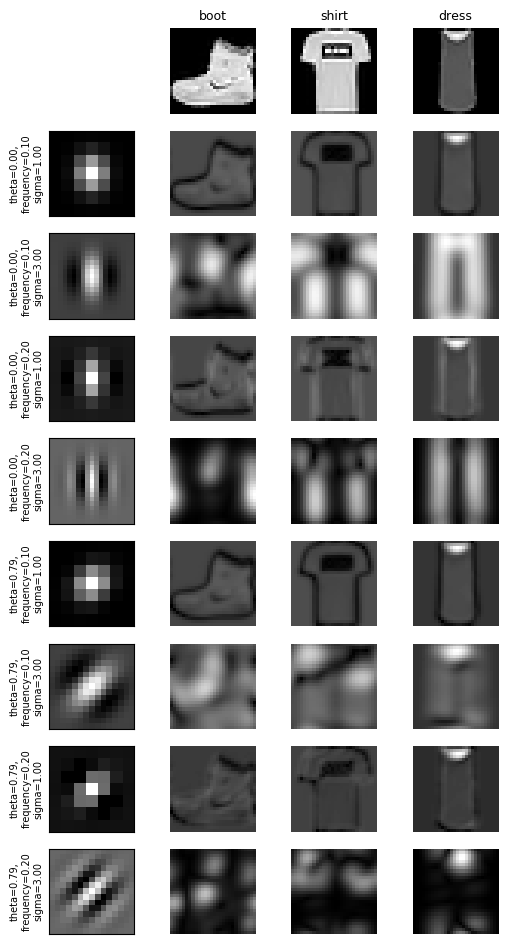

In [22]:
# Fetch some Fashion-MNIST images
boot = X_fm[0].reshape(28, 28)
shirt = X_fm[1].reshape(28, 28)
dress = X_fm[2].reshape(28, 28)
image_names = ('boot', 'shirt', 'dress')
images = (boot, shirt, dress)

plot_filter_bank(images)
plt.rcParams['figure.dpi'] = 100

## Convolutional neural nets
* Finding relationships between individual pixels and the correct class is hard
* We want to discover 'local' patterns (edges, lines, endpoints)
* Representing such local patterns as features makes it easier to learn from them
* We could use convolutions, but how to choose the filters?

<img src="../images/10_patches.png" alt="ml" style="width: 300px;  margin-left: auto; margin-right: auto;"/>

### Convolutional Neural Networks (ConvNets)
* Instead on manually designing the filters, we can also _learn_ them based on data
    * Choose filter sizes (manually), initialize with small random weights
* Forward pass: Convolutional layer slides the filter over the input, generates the output
* Backward pass: Update the filter weights according to the loss gradient
* Illustration for 1 filter: 

<img src="../images/cnn.png" alt="ml" style="width: 500px;  margin-left: auto; margin-right: auto;"/>


### Convolutional layers: Feature maps
* One filter is not sufficient to detect all relevant patterns in an image
* A convolutional layer applies and learns $d$ filter in parallel  
* Slide $d$ filters across the input image (in parallel) -> a (1x1xd) output per patch
* Reassemble into a _feature map_ with $d$ 'channels', a (width x height x d) tensor.

<img src="../images/10_convolution.png" alt="ml" style="width: 400px;  margin-left: auto; margin-right: auto;"/>

### Border effects (zero padding)
* Consider a 5x5 image and a 3x3 filter: there are only 9 possible locations, hence the output is a 3x3 feature map
* If we want to maintain the image size, we use _zero-padding_, adding 0's all around the input tensor.

<img src="../images/10_padding.png" alt="ml" style="float: left; width: 45%;"/>
<img src="../images/10_padding_2.png" alt="ml" style="float: left; width: 45%;"/>

### Undersampling (striding)
* Sometimes, we want to _downsample_ a high-resolution image
    * Faster processing, less noisy (hence less overfitting)
* One approach is to _skip_ values during the convolution
    * Distance between 2 windows: _stride length_
* Example with stride length 2 (without padding):
    
<img src="../images/10_strides.png" alt="ml" style="width: 500px;  margin-left: auto; margin-right: auto;"/>

### Max-pooling
* Another approach to shrink the input tensors is _max-pooling_ :
    - Run a filter with a fixed stride length over the image
        - Usually 2x2 filters and stride lenght 2
    - The filter simply returns the _max_ (or _avg_ ) of all values
* Agressively reduces the number of weights (less overfitting)
* Information from every input node spreads more quickly to output nodes
    - In `pure` convnets, one input value spreads to 3x3 nodes of the first layer, 5x5 nodes of the second, etc.
    - Without maxpooling, you need much deeper networks, harder to train
* Increases _translation invariance_ : patterns can affect the predictions no matter where they occur in the image

## Convolutional nets in practice
* ConvNets usually use multiple convolutional layers to learn patterns at different levels of abstraction
    * Find local patterns first (e.g. edges), then patterns across those patterns
* Use MaxPooling layers to reduce resolution, increase translation invariance
* Use sufficient filters in the first layer (otherwise information gets lost)
* In deeper layers, use increasingly more filters
    * Preserve information about the input as resolution descreases
    * Avoid decreasing the number of activations (resolution x nr of filters)

Example with Keras:
    
* `Conv2D` for 2D convolutional layers
    - 32 filters (default), randomly initialized (from uniform distribution)
    - Deeper layers use 64 filters
    - Filter size is 3x3
    - ReLU activation to simplify training of deeper networks
* `MaxPooling2D` for max-pooling
    - 2x2 pooling reduces the number of inputs by a factor 4
        
``` python
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
```

In [23]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Observe how the input image on 28x28x1 is transformed to a 3x3x64 feature map  
* Convolutional layer:
    * No zero-padding: every output 2 pixels less in every dimension
    * 320 weights: (3x3 filter weights + 1 bias) * 32 filters
* After every MaxPooling, resolution halved in every dimension

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Completing the network

* To classify the images, we still need a Dense and Softmax layer.
* We need to flatten the 3x3x64 feature map to a vector of size 576

``` python
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
```

In [25]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Complete network

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [27]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Run the model on MNIST dataset
* Train and test as usual (takes about 5 minutes): 99% accuracy
    * Compared to 97,8% accuracy with the dense architecture

###### Model was trained beforehand and saved. Uncomment if you want to run from scratch
``` python
import pickle
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0,
                    validation_data=(test_images, test_labels))

model.save(os.path.join(model_dir, 'cats_and_dogs_small_0.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_0_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

10000/10000 [==============================] - 3s 266us/sample - loss: 0.0355 - accuracy: 0.9902
Accuracy:  0.9902


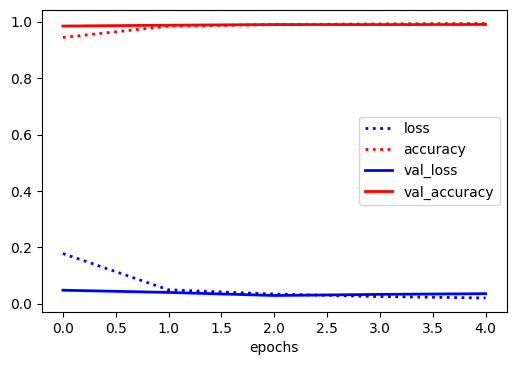

In [29]:
from tensorflow.keras.models import load_model

model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_0.h5'))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Accuracy: ", test_acc)

history = pickle.load(open("../data/models/cats_and_dogs_small_0_history.p", "rb"))
pd.DataFrame(history).plot(lw=2,style=['b:','r:','b-','r-']);
plt.xlabel('epochs');

Tip:
* Training ConvNets can take a lot of time
* Save the trained model (and history) to disk so that you can reload it later

``` python
model.save(os.path.join(model_dir, 'cats_and_dogs_small.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

## Cats vs Dogs
* A more realistic dataset: [Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats/data)
    - Colored JPEG images, different sizes
    - Not nicely centered, translation invariance is important
* Preprocessing
    - Create balanced subsample of 4000 colored images 
        - 2000 for training, 1000 validation, 1000 testing
    - Decode JPEG images to floating-point tensors
    - Rescale pixel values to [0,1]
    - Resize images to 150x150 pixels

###### Data is already prepared in the 'data' folder, you don't need to run this
###### Uncomment if you want to run from scratch

```python
import os, shutil 
# Download data from https://www.kaggle.com/c/dogs-vs-cats/data
# Uncompress `train.zip` into the `original_dataset_dir`
original_dataset_dir = '../data/cats-vs-dogs_original'

# The directory where we will
# store our smaller dataset
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)
    
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)
    os.mkdir(train_dogs_dir)
    os.mkdir(validation_cats_dir)
    os.mkdir(validation_dogs_dir)
    os.mkdir(test_cats_dir)
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)
```

### Data generators
* `ImageDataGenerator`: allows to encode, resize, and rescale JPEG images
* Returns a Python _generator_ we can endlessly query for batches of images
* Separately for training, validation, and test set

``` python
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, # Directory with images
        target_size=(150, 150), # Resize images 
        batch_size=20, # Return 20 images at a time
        class_mode='binary') # Binary labels
```

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


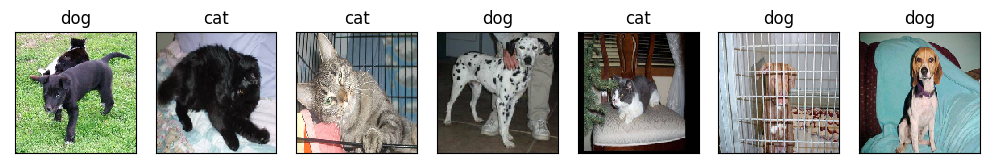

In [31]:
for data_batch, labels_batch in train_generator:
    plt.figure(figsize=(10,5))
    for i in range(7):
        plt.subplot(171+i)
        plt.xticks([])
        plt.yticks([])
        imgplot = plt.imshow(data_batch[i])
        plt.title('cat' if labels_batch[i] == 0 else 'dog')
        plt.tight_layout()
    break

In [32]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Since the images are larger and more complex, we add another convolutional layer and increase the number of filters to 128.

``` python
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))



```

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

### Training
* The `fit` function also supports generators
    - 100 steps per epoch (batch size: 20 images per step), for 30 epochs
    - Provide a separate generator for the validation data
    
``` python
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history = model.fit(
      train_generator, steps_per_epoch=100,
      epochs=30, verbose=0,
      validation_data=validation_generator,
      validation_steps=50)
```

In [34]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

###### Uncomment to run. Training takes about 1 hours on CPU
###### We save the trained model (and history) to disk so that we can reload it later
###### Note: TensorFlow 2.1 seems to have a bug resulting in an error message 'sample_weight modes were coerced'
``` python
import pickle
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30, verbose=1,
      validation_data=validation_generator,
      validation_steps=50)
model.save(os.path.join(model_dir, 'cats_and_dogs_small_1.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_1_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

#### Results
* The network seems to be overfitting. Validation accuracy is stuck at 75% while the training accuracy reaches 100%
* There are many things we can do:
    - Regularization (e.g. Dropout, L1/L2, Batch Normalization,...)
    - Generating more training data
    - Meta-learning: Use pretrained rather than randomly initialized filters

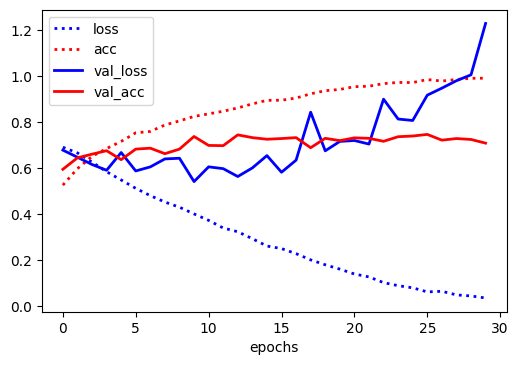

In [35]:
import pickle
history = pickle.load(open("../data/models/cats_and_dogs_small_1_history.p", "rb"))
pd.DataFrame(history).plot(lw=2,style=['b:','r:','b-','r-']);
plt.xlabel('epochs');

### Data augmentation
* Generate new images via image transformations
    - Images will be randomly transformed _every epoch_
* We can again use a data generator to do this

``` python
datagen = ImageDataGenerator(
      rotation_range=40,     # Rotate image up to 40 degrees
      width_shift_range=0.2, # Shift image left-right up to 20% of image width
      height_shift_range=0.2,# Shift image up-down up to 20% of image height
      shear_range=0.2,       # Shear (slant) the image up to 0.2 degrees
      zoom_range=0.2,        # Zoom in up to 20%
      horizontal_flip=True,  # Horizontally flip the image
      fill_mode='nearest')
```

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Example

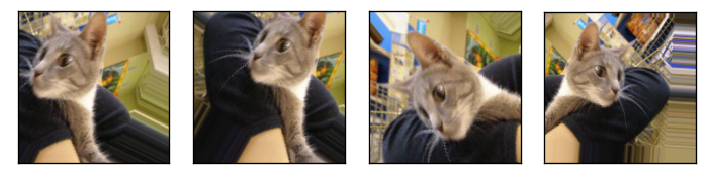

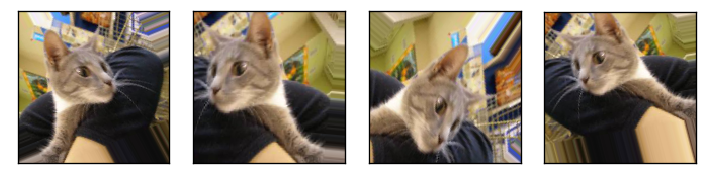

In [37]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image
plt.rcParams['figure.dpi'] = 120

train_cats_dir = os.path.join(base_dir, 'train', 'cats')
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[5]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
for a in range(2):
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(141+i) 
        plt.xticks([]) 
        plt.yticks([])
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 4 == 0:
            break
        
    plt.tight_layout()
    plt.show()

We also add Dropout before the Dense layer

``` python
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
```

In [38]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


###### Training takes about 6 hours on CPU, 30 min on 1 GPU
###### Uncomment to run

``` python
history = model.fit_generator(
      train_generator,
      steps_per_epoch=60, # 2000 images / batch size 32
      epochs=100,  verbose=0,
      validation_data=validation_generator,
      validation_steps=30) # About 1000/32
model.save(os.path.join(model_dir, 'cats_and_dogs_small_2.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_2_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

(Almost) no more overfitting!

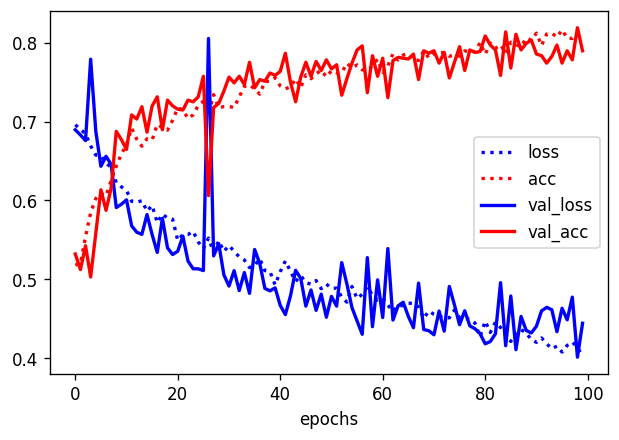

In [40]:
history = pickle.load(open("../data/models/cats_and_dogs_small_2_history.p", "rb"))
pd.DataFrame(history).plot(lw=2,style=['b:','r:','b-','r-']);
plt.xlabel('epochs');

## Interpreting the model
* Let's see what the convnet is learning exactly by observing the intermediate feature maps
    - A layer's output is also called its _activation_
* We can choose a specific test image, and observe the outputs
* We can retrieve and visualize the activation for every filter for every layer

* Layer 0: has activations of resolution 148x148 for each of its 32 filters
* Layer 2: has activations of resolution 72x72 for each of its 64 filters
* Layer 4: has activations of resolution 34x34 for each of its 128 filters
* Layer 6: has activations of resolution 15x15 for each of its 128 filters

In [41]:
from tensorflow.keras.models import load_model

model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_2.h5'))
model.summary()  # As a reminder.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [42]:
img_path = os.path.join(base_dir, 'test/cats/cat.1700.jpg')

# We preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

In [43]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

* To extract the activations, we create a new model that outputs the trained layers
    * 8 output layers in total (only the convolutional part)
* We input a test image for prediction and then read the relevant outputs

``` python
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
```

Output of the first Conv2D layer, 3rd channel (filter):
* Similar to a diagonal edge detector
* Your own channels may look different

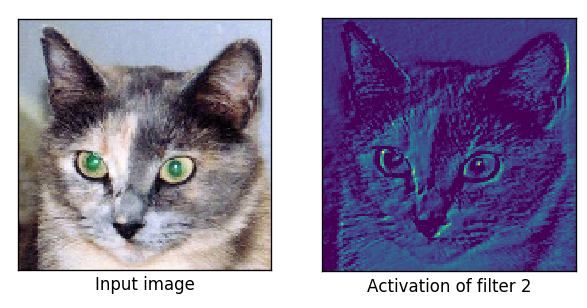

In [44]:
plt.rcParams['figure.dpi'] = 120
first_layer_activation = activations[0]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_tensor[0])
ax2.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 2');

Output of filter 16:
* Cat eye detector?

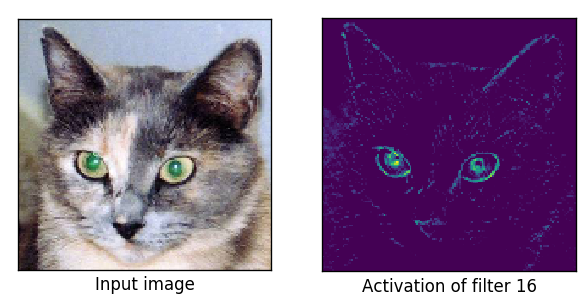

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_tensor[0])
ax2.matshow(first_layer_activation[0, :, :,16], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 16');

The same filter responds quite differently for other inputs

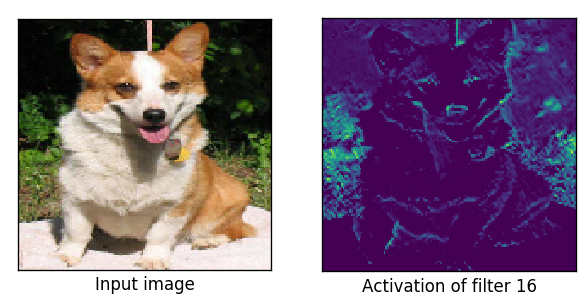

In [46]:
img_path = os.path.join(base_dir, 'test/dogs/dog.1528.jpg')

# We preprocess the image into a 4D tensor
img = image.load_img(img_path, target_size=(150, 150))
img_tensor2 = image.img_to_array(img)
img_tensor2 = np.expand_dims(img_tensor2, axis=0) 
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor2 /= 255.

activations2 = activation_model.predict(img_tensor2)

plt.rcParams['figure.dpi'] = 120
first_layer_activation2 = activations2[0]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_tensor2[0])
ax2.matshow(first_layer_activation2[0, :, :, 16], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 16');

In [47]:
images_per_row = 16

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

def plot_activations(layer_index, activations):
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

* First 2 convolutional layers: various edge detectors

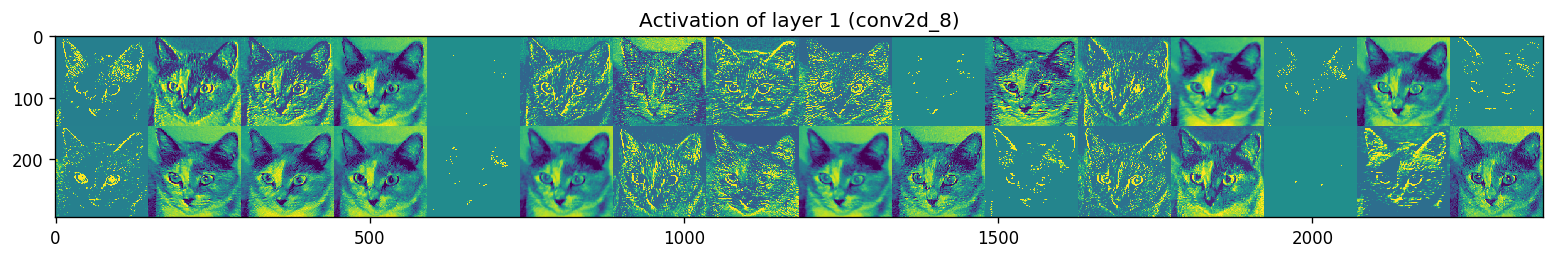

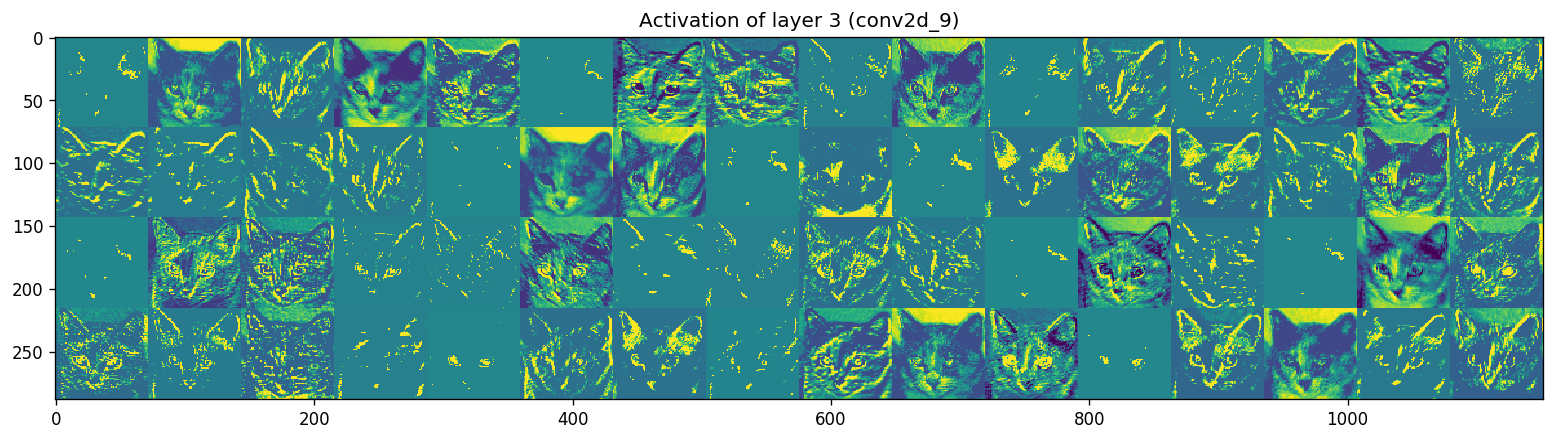

In [48]:
plot_activations(0, activations)
plot_activations(2, activations)

* 3rd convolutional layer: increasingly abstract: ears, eyes

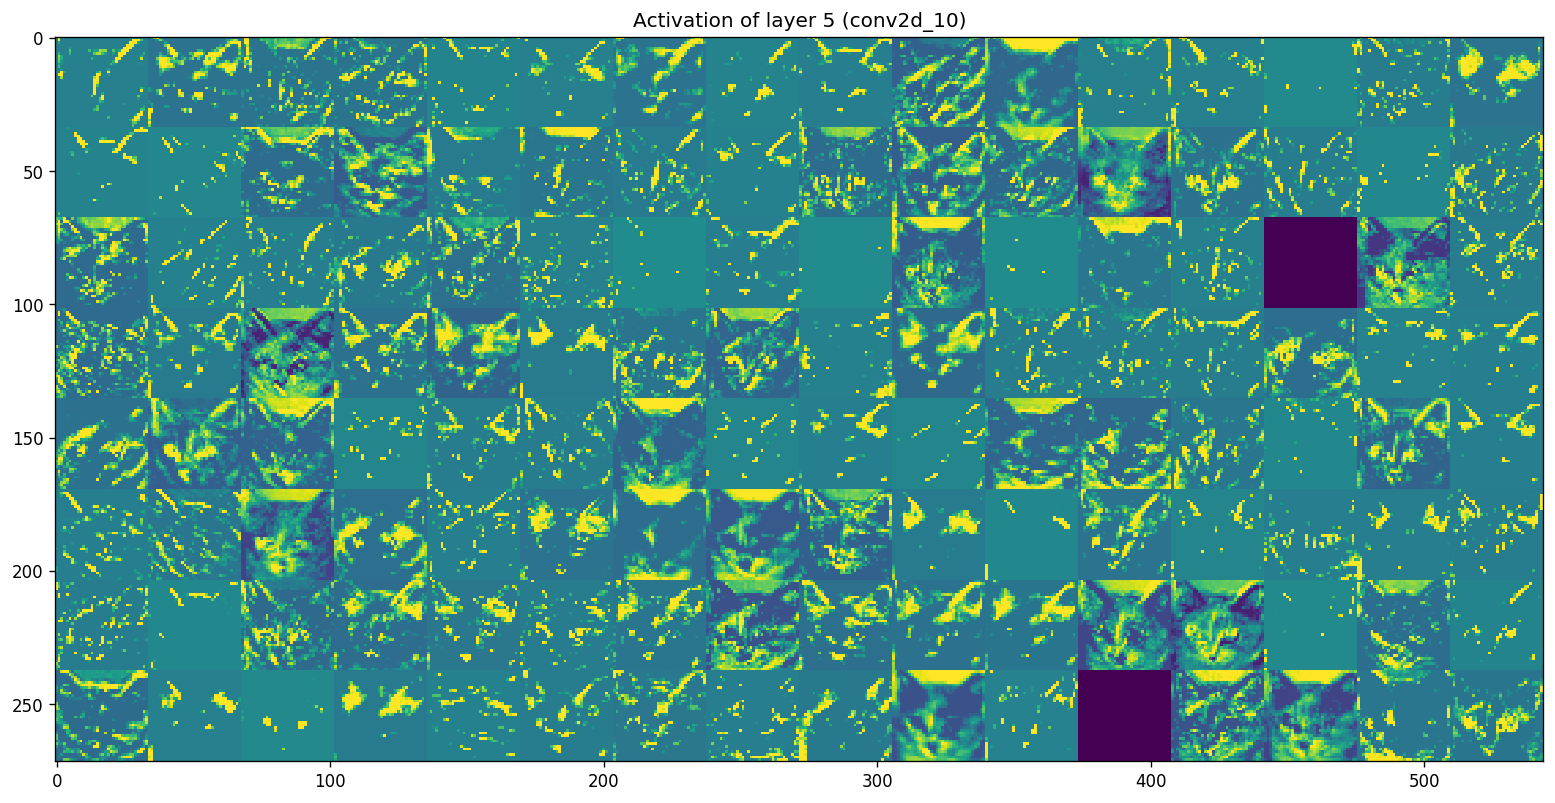

In [49]:
plot_activations(4, activations)

* Last convolutional layer: more abstract patterns
* Empty filter activations: input image does not have the information that the filter was interested in


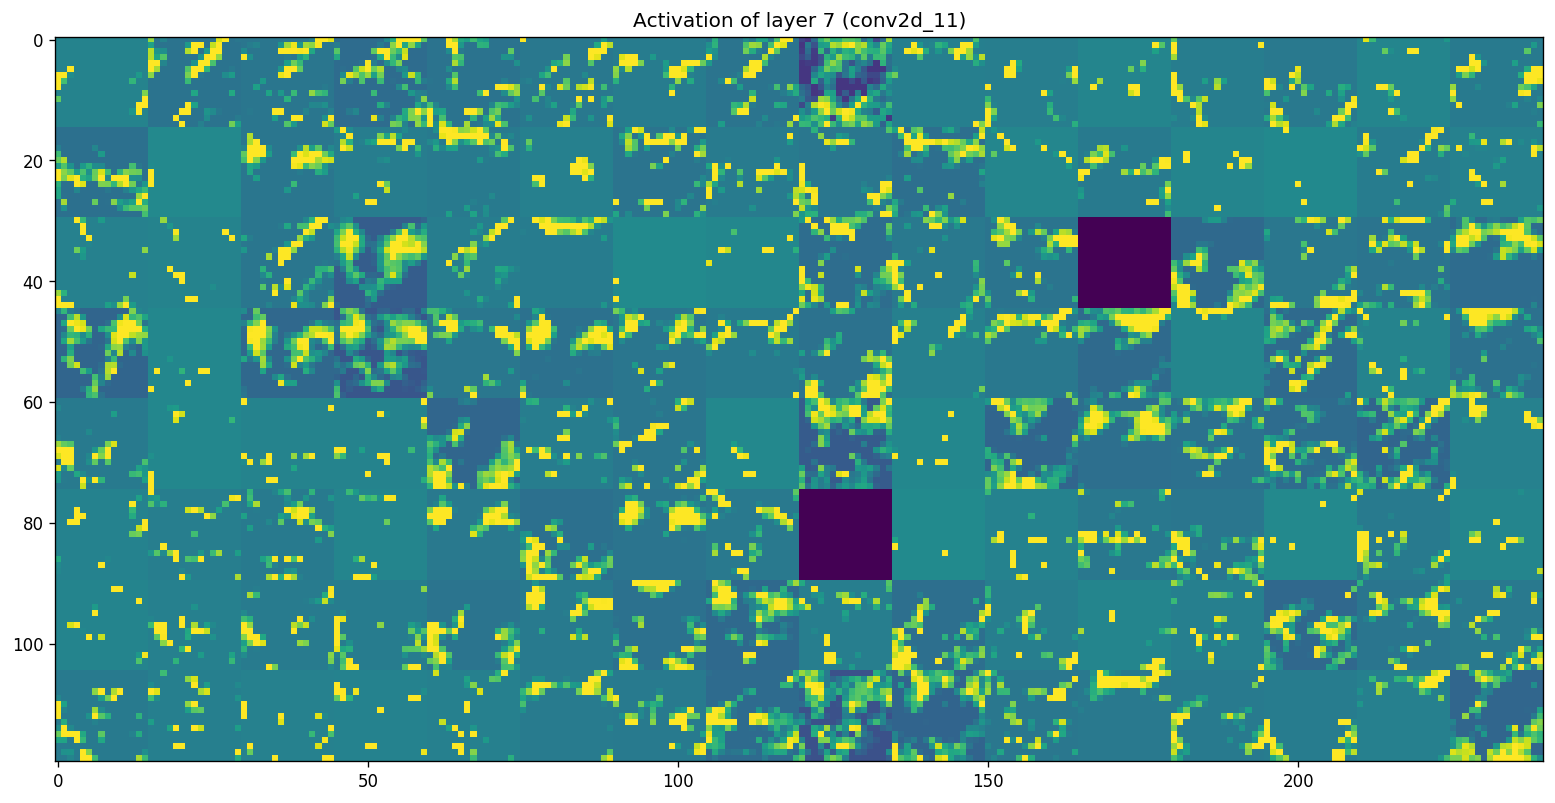

In [50]:
plot_activations(6, activations)

* Same layer, with dog image input
    * Very different activations

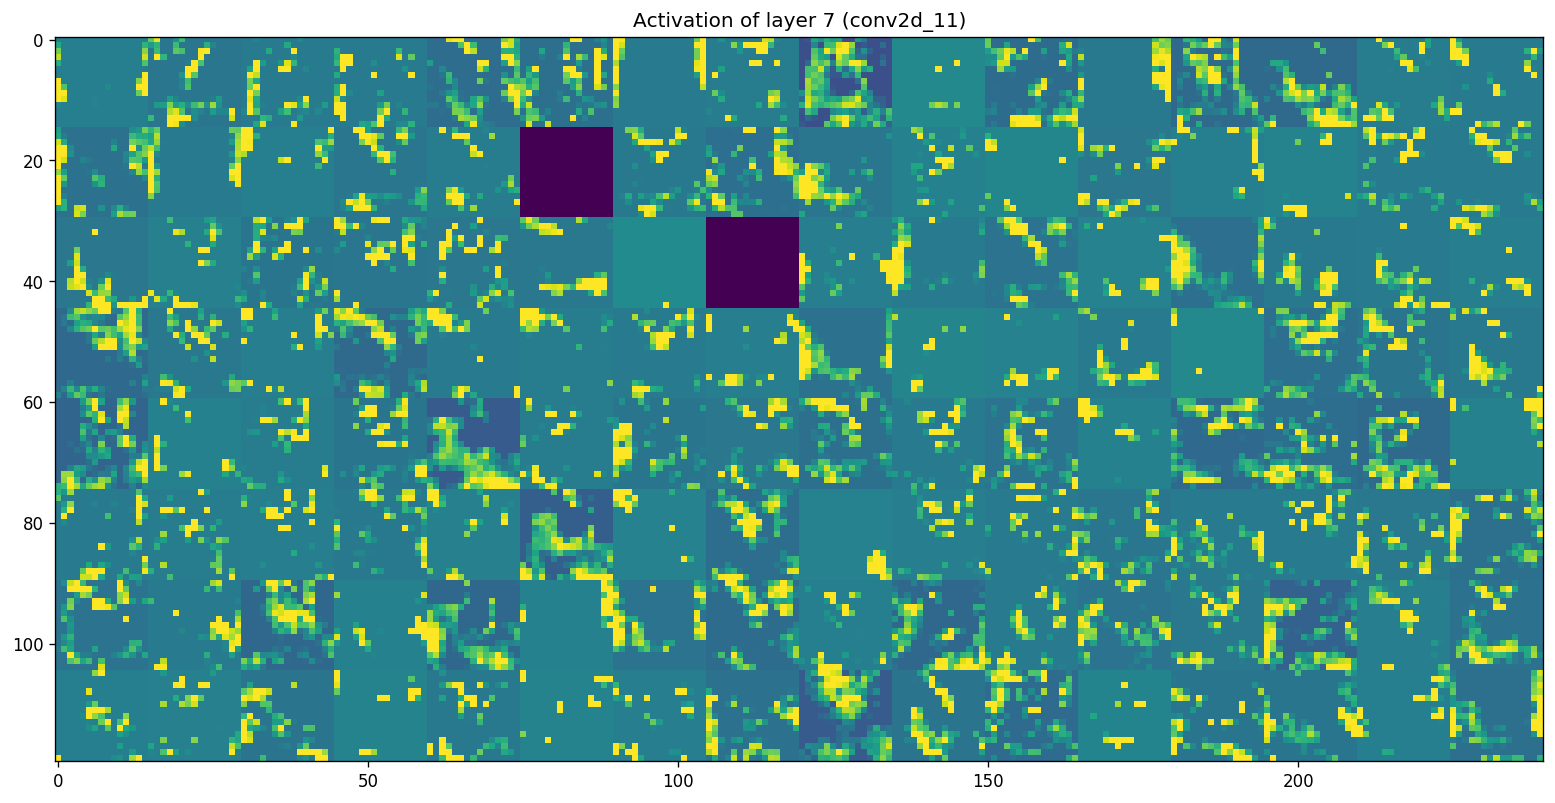

In [51]:
plot_activations(6, activations2)

### Spatial hierarchies
* Deep convnets can learn _spatial hierarchies_ of patterns
    - First layer can learn very local patterns (e.g. edges)
    - Second layer can learn specific combinations of patterns
    - Every layer can learn increasingly complex _abstractions_
    
<img src="../images/10_hierarchy.png" alt="ml" style="width: 500px;  margin-left: auto; margin-right: auto;"/>

### Visualizing the learned filters
* The filters themselves can be visualized by finding the input image that they are maximally responsive to
* _gradient ascent in input space_ : start from a random image, use loss to update the pixel values to values that the filter responds to more strongly

``` python
    from keras import backend as K
    input_img = np.random.random((1, size, size, 3)) * 20 + 128.
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0] # Compute gradient
    for i in range(40): # Run gradient ascent for 40 steps
        loss_v, grads_v = K.function([input_img], [loss, grads])
        input_img_data += grads_v * step
```

In [83]:
tf.compat.v1.disable_eager_execution()

# Convert tensor to image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

def visualize_filter(layer_name):
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(10, 10))
    plt.imshow((results * 255).astype(np.uint8))

    plt.show()

* Learned filters of second convolutional layer
* Mostly general, some respond to specific shapes/colors

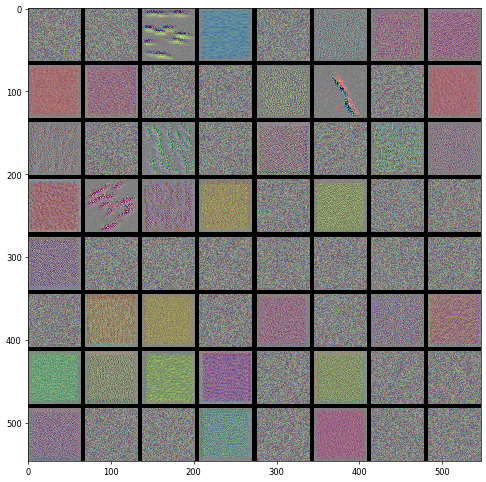

In [89]:
from tensorflow.keras import backend as K

plt.rcParams['figure.dpi'] = 60
visualize_filter('conv2d_9')

* Learned filters of last convolutional layer
* More focused on center, some vague cat/dog head shapes

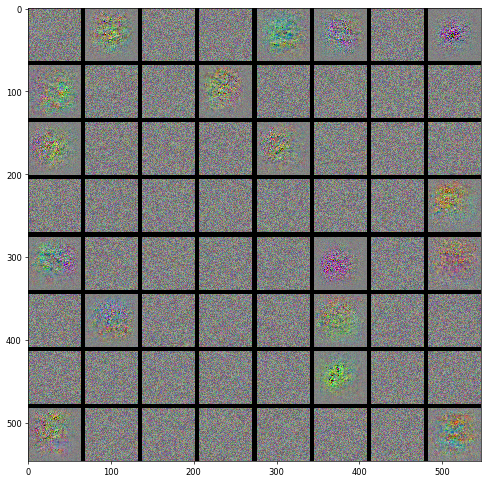

In [90]:
visualize_filter('conv2d_11')

Let's do this again for the `VGG16` network pretrained on `ImageNet` (much larger)
    
``` python
model = VGG16(weights='imagenet', include_top=False)
```

In [92]:
from tensorflow.keras.applications import VGG16

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [93]:
# VGG16 model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

* Visualize convolution filters 0-2 from layer 5 of the VGG network trained on ImageNet
* Some respond to dots or waves in the image

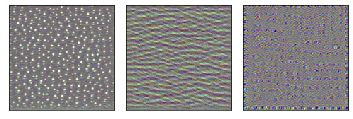

In [94]:
for i in range(3):
    plt.subplot(131+i) 
    plt.xticks([]) 
    plt.yticks([])
    plt.imshow(generate_pattern('block3_conv1', i))
plt.tight_layout()
plt.show();

First 64 filters for 1st convolutional layer in block 1: simple edges and colors

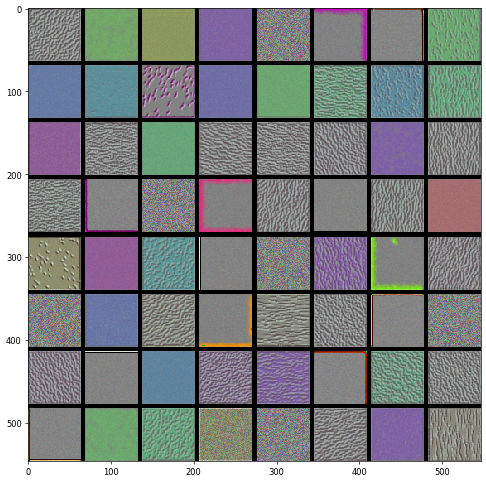

In [113]:
plt.rcParams['figure.dpi'] = 60
visualize_filter('block1_conv1')

Filters in 2nd block of convolution layers: simple textures (combined edges and colors)

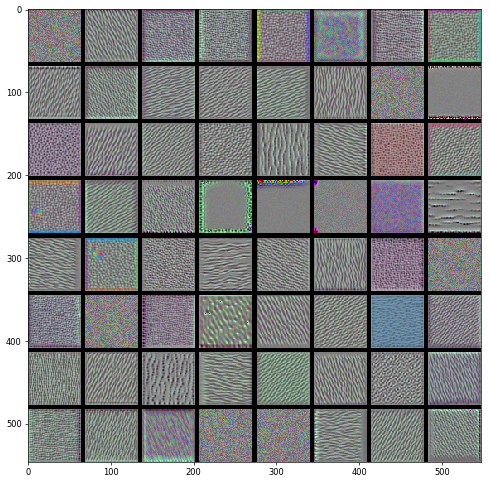

In [57]:
visualize_filter('block2_conv1')

Filters in 3rd block of convolution layers: more natural textures

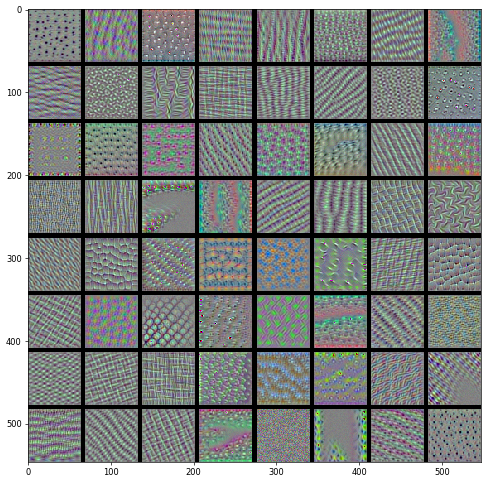

In [58]:
visualize_filter('block3_conv1')

Filters in 4th block of convolution layers: feathers, eyes, leaves,...

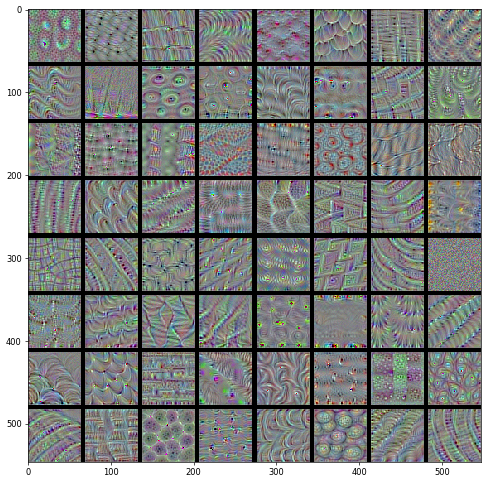

In [59]:
visualize_filter('block4_conv1')

## Visualizing class activation
* We can also visualize which part of the input image had the greatest influence on the final classification
    - Helpful for interpreting what the model is paying attention to
* _Class activation maps_ : produce heatmap over the input image
    - Take the output feature map of a convolution layer (e.g. the last one)
    - Weigh every filter by the gradient of the class with respect to the filter

<img src="../images/activation_map.png" alt="ml" style="width: 600px;  margin-left: auto; margin-right: auto;"/>

Illustration (cats vs dogs)
* These were the output feature maps of the last convolutional layer
    * These are flattened and fed to the dense layer
* Compute gradient of the 'cat' node output wrt. every filter output (pixel) here
    * Average the gradients per filter, use that as the filter weight
* Take the weighted sum of all filter maps to get the class activation map

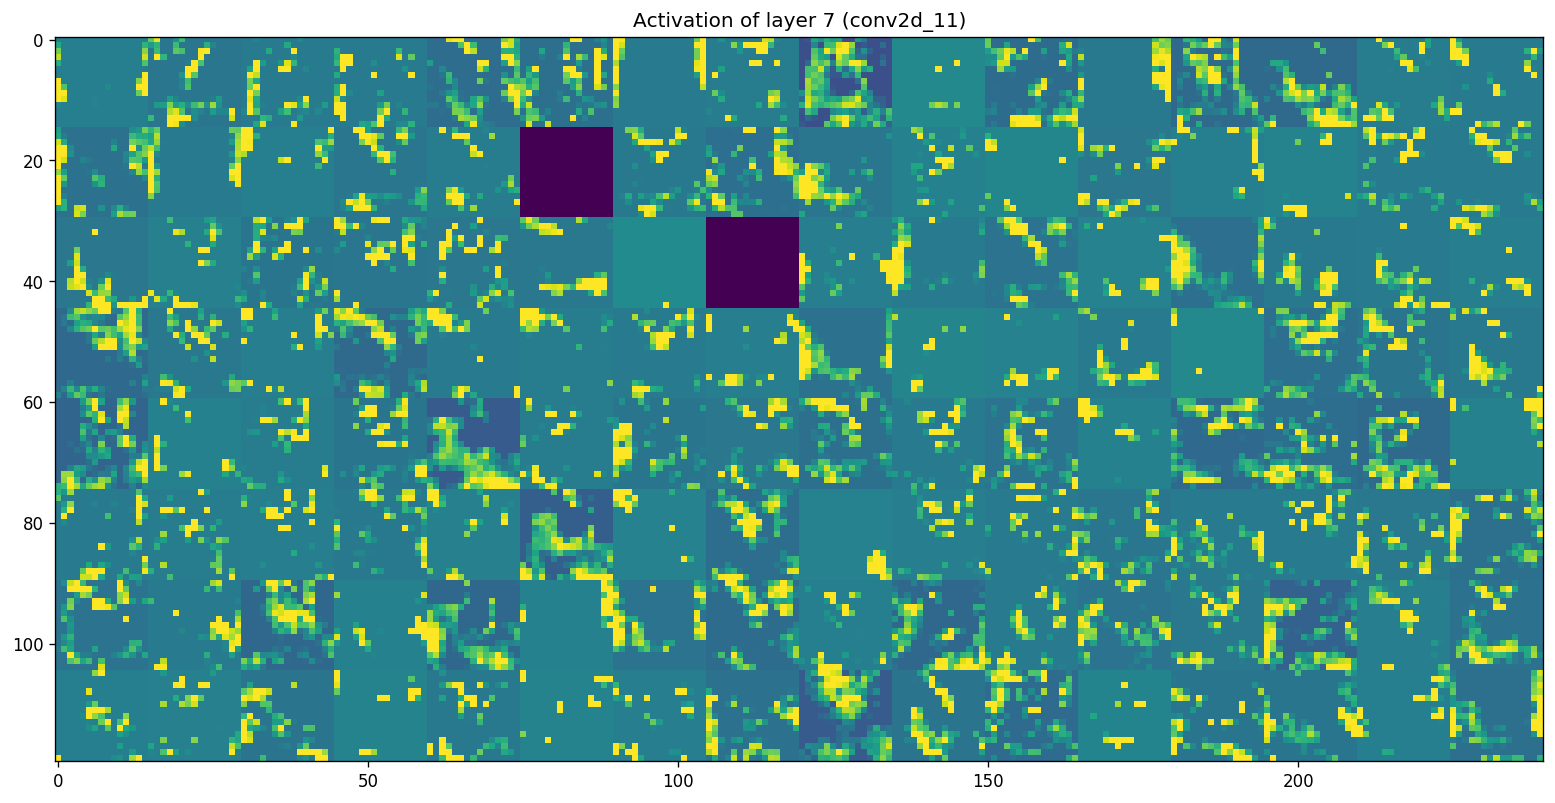

In [116]:
plot_activations(6, activations2)

More realistic example:
* Try VGG (including the dense layers) and an image from ImageNet
``` python
model = VGG16(weights='imagenet')
```
<img src="../images/10_elephants.jpg" alt="ml" style="float: left; width: 75%;"/>

In [95]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

K.clear_session()
# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

In [96]:
## From Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = '../images/10_elephants.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation

heatmap = np.mean(conv_layer_output_value, axis=-1)

Preprocessing  
* Load image
* Resize to 224 x 224 (what VGG was trained on)
* Do the same preprocessing (Keras VGG utility)

``` python
from keras.applications.vgg16 import preprocess_input
img_path = '../images/10_elephants.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # Transform to batch of size (1, 224, 224, 3)
x = preprocess_input(x)
```

* Sanity test: do we get the right prediction?
    
``` python
preds = model.predict(x)
```

In [97]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]


Visualize the class activation map

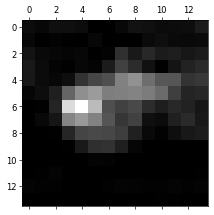

In [98]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [111]:
# pip install opencv-python
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('../images/elephant_cam.jpg', superimposed_img)

True

Superimposed on the original image

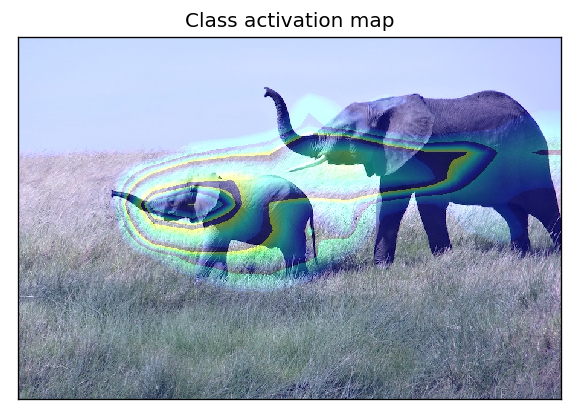

In [115]:
img = cv2.imread('../images/elephant_cam.jpg')
RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.rcParams['figure.dpi'] = 120
plt.imshow(RGB_im)
plt.title('Class activation map')
plt.xticks([])
plt.yticks([])
plt.show()

## Using pretrained networks
* We can re-use pretrained networks instead of training from scratch
* Learned features can be a generic model of the visual world
* Use _convolutional base_ to contruct features, then train any classifier on new data
* Also called _transfer learning_ , which is a kind of _meta-learning_

<img src="../images/10_pretraining.png" alt="ml" style="width: 600px;  margin-left: auto; margin-right: auto;"/>

* Let's instantiate the VGG16 model (without the dense layers)
* Final feature map has shape (4, 4, 512)
``` python
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
```

In [114]:
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(150, 150, 3))

In [115]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Using pre-trained networks: 3 ways
* Fast feature extraction (similar task, little data)
    - Call `predict` from the convolutional base to build new features
    - Use outputs as input to a new neural net (or other algorithm)
* End-to-end tuning (similar task, lots of data + data augmentation)
    - Extend the convolutional base model with a new dense layer
    - Train it end to end on the new data (expensive!)
* Fine-tuning (somewhat different task)
    - Unfreeze a few of the top convolutional layers, and retrain
        - Update only the more abstract representations
    
<img src="../images/pretraining.png" alt="ml" style="width: 700px;  margin-left: auto; margin-right: auto;"/>

### Fast feature extraction (without data augmentation)
* Run every batch through the pre-trained convolutional base
    
``` python
generator = datagen.flow_from_directory(dir, target_size=(150, 150),
        batch_size=batch_size, class_mode='binary')
for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
```

In [116]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [117]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

* Build Dense neural net (with Dropout)
* Train and evaluate with the transformed examples

``` python
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
```

In [118]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, verbose=0,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

model.save(os.path.join(model_dir, 'cats_and_dogs_small_3a.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_3a_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

* Validation accuracy around 90%, much better!
* Still overfitting, despite the Dropout: not enough training data

Max val_acc 0.9070000052452087


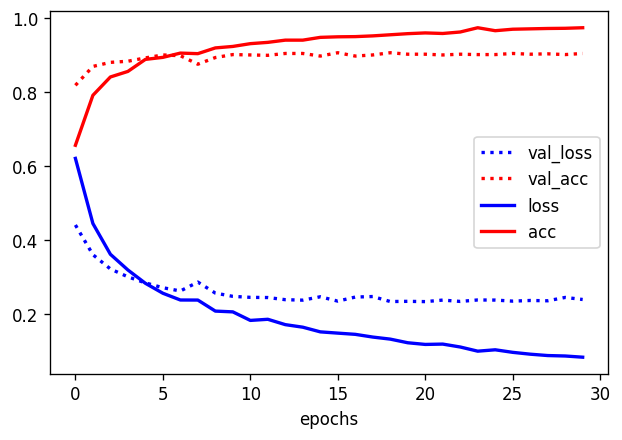

In [128]:
history = pickle.load(open("../data/models/cats_and_dogs_small_3a_history.p", "rb"))
print("Max val_acc",np.max(history['val_acc']))
pd.DataFrame(history).plot(lw=2,style=['b:','r:','b-','r-']);
plt.xlabel('epochs');

### Fast feature extraction (with data augmentation)
* Simply add the Dense layers to the convolutional base
* _Freeze_ the convolutional base (before you compile)
    * Without freezing, you train it end-to-end (expensive)

``` python
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False
```

In [126]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False

In [127]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [130]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Takes a long time. Uncomment if you really want to run it
``` python
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=0)
model.save(os.path.join(model_dir, 'cats_and_dogs_small_3b.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_3b_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

Data augmentation and training (takes a LONG time) 
``` python
train_datagen = ImageDataGenerator(
      rescale=1./255, rotation_range=40, width_shift_range=0.2,
      height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
      horizontal_flip=True, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(dir,
      target_size=(150, 150), batch_size=20, class_mode='binary')
history = model.fit_generator(
      train_generator, steps_per_epoch=100, epochs=30,
      validation_data=validation_generator, validation_steps=50)
```

We now get about 90% accuracy again, and very little overfitting

Max val_acc 0.906


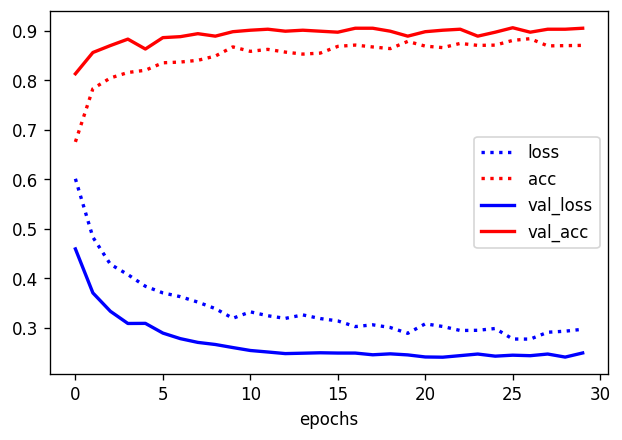

In [129]:
history = pickle.load(open("../data/models/cats_and_dogs_small_3b_history.p", "rb"))
print("Max val_acc",np.max(history['val_acc']))
pd.DataFrame(history).plot(lw=2,style=['b:','r:','b-','r-']);
plt.xlabel('epochs');

### Fine-tuning
* Add your custom network on top of an already trained base network.
* Freeze the base network, but unfreeze the last block of conv layers.

``` python
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    else:
        layer.trainable = False
```

Visualized

<img src="../images/10_vgg16_fine_tuning.png" alt="ml" style="float: left; width: 45%;"/>
<img src="../images/10_vgg16_fine_tuning2.png" alt="ml" style="float: left; width: 45%;"/>

In [133]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [134]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

* Load trained network, finetune
    - Use a small learning rate, large number of epochs
    - You don't want to unlearn too much: _catastrophic forgetting_
    
``` python
model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_3b.h5'))
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
history = model.fit(
      train_generator, steps_per_epoch=100, epochs=100,
      validation_data=validation_generator,
      validation_steps=50)
```

##### Takes a long time, uncomment if you really want to run it
``` python
from keras.models import load_model
model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_3b.h5'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10, # Repeat with epochs=100
      validation_data=validation_generator,
      validation_steps=50)
model.save(os.path.join(model_dir, 'cats_and_dogs_small_4.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_4_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

Almost 95% accuracy. The curves are quite noisy, though.

Max val_acc 0.948


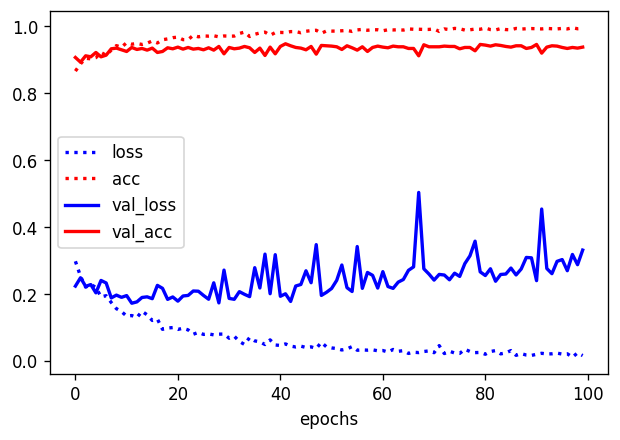

In [130]:
history = pickle.load(open("../data/models/cats_and_dogs_small_3c_history.p", "rb"))
print("Max val_acc",np.max(history['val_acc']))
pd.DataFrame(history).plot(lw=2,style=['b:','r:','b-','r-']);
plt.xlabel('epochs');

* We can smooth the learning curves using a running average

Max val_acc 0.9408402440315202


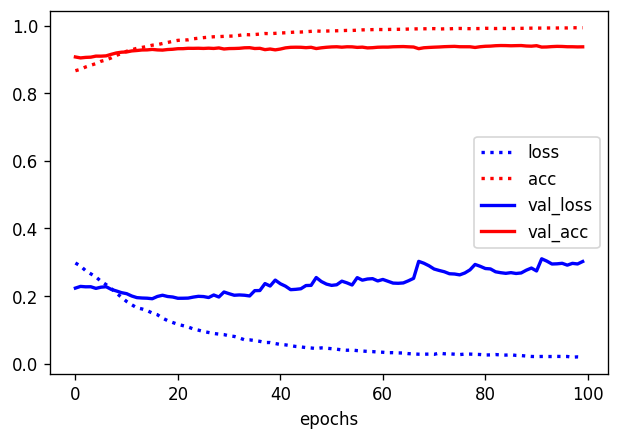

In [138]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_history = {}
smooth_history['loss'] = smooth_curve(history['loss'])
smooth_history['acc'] = smooth_curve(history['acc'])
smooth_history['val_loss'] = smooth_curve(history['val_loss'])
smooth_history['val_acc'] = smooth_curve(history['val_acc'])

print("Max val_acc",np.max(smooth_history['val_acc']))
pd.DataFrame(smooth_history).plot(lw=2,style=['b:','r:','b-','r-']);
plt.xlabel('epochs');

Finally, evaluate the trained model on the test set. This is consistent with the validation results.

In [137]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_3c.h5'))
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 126s 3s/step - loss: 0.3771 - acc: 0.9390
test acc: 0.939


## Take-aways
* Convnets are ideal for attacking visual-classification problems.
* They learn a hierarchy of modular patterns and concepts to represent the visual world.
* Representations are easy to inspect
* Data augmentation helps fight overfitting
* You can use a pretrained convnet to build better models via transfer learning